<a href="https://colab.research.google.com/github/h0806449f/Pytorch/blob/main/DB_04_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Domain Libraries
vision, text, audio, recommendation ...

In [8]:
import torch
from torch import nn

torch.__version__

'2.0.0+cu118'

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Get data
Subset of the Food101 dataset.  
  
Food101 starts 101 different classes.  
Here starts with 3 classes and 10% images.

In [10]:
import requests
import zipfile
from pathlib import Path

# Set path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If image folder doesn't exist, download and prepare it
if image_path.is_dir():
    print(f"{image_path} directory already exist, skipping download")
else:
    print(f"{image_path} doesn't exist, creating")
    image_path.mkdir(parents=True, exist_ok=True)

# Download subset dataset
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    f.write(request.content)

# Unzip the file
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping the file")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exist, skipping download
Unzipping the file


# 2. Becoming one with the data (data preparation and data exploration)

In [12]:
# Function
import os

def walk_through_dir(dir_path):
    """Walk through dir_path, returning the content in it"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} dirs and {len(filenames)} images in {dirpath}.")

In [14]:
# Check
walk_through_dir(image_path)

There are 2 dirs and 0 images in data/pizza_steak_sushi.
There are 3 dirs and 0 images in data/pizza_steak_sushi/train.
There are 0 dirs and 72 images in data/pizza_steak_sushi/train/sushi.
There are 0 dirs and 78 images in data/pizza_steak_sushi/train/pizza.
There are 0 dirs and 75 images in data/pizza_steak_sushi/train/steak.
There are 3 dirs and 0 images in data/pizza_steak_sushi/test.
There are 0 dirs and 31 images in data/pizza_steak_sushi/test/sushi.
There are 0 dirs and 25 images in data/pizza_steak_sushi/test/pizza.
There are 0 dirs and 19 images in data/pizza_steak_sushi/test/steak.


In [15]:
# Setup training and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# 2.1 Visualizing image  
  
1. Get all of the image paths
2. Pick random image path  (`random.choice()`)
3. Get image class name  (`pathlib.Path.parent.stem`)
4. Open image  (`PIL`)
5. Show image and print metadata

In [16]:
image_path

PosixPath('data/pizza_steak_sushi')

data/pizza_steak_sushi/train/sushi/821108.jpg
sushi
Random image path: data/pizza_steak_sushi/train/sushi/821108.jpg
Image height: 383
Image width: 512


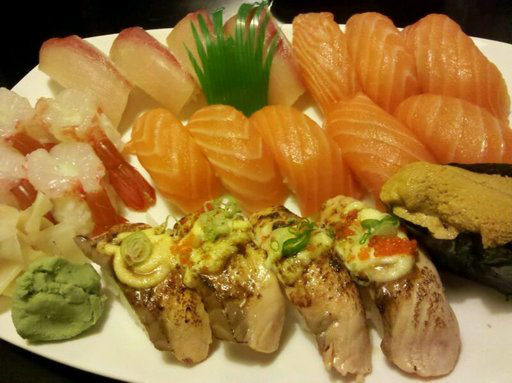

In [25]:
import random
from PIL import Image

# Set random seed
random.seed(42)

# 1. Get all image paths
"""
先前已經設置
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
"""
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick random path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class (name of the dir - based on our setting)
image_class = random_image_path.parent.stem   # parent : data/pizza_steak_sushi/train/sushi / stem : last dir
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

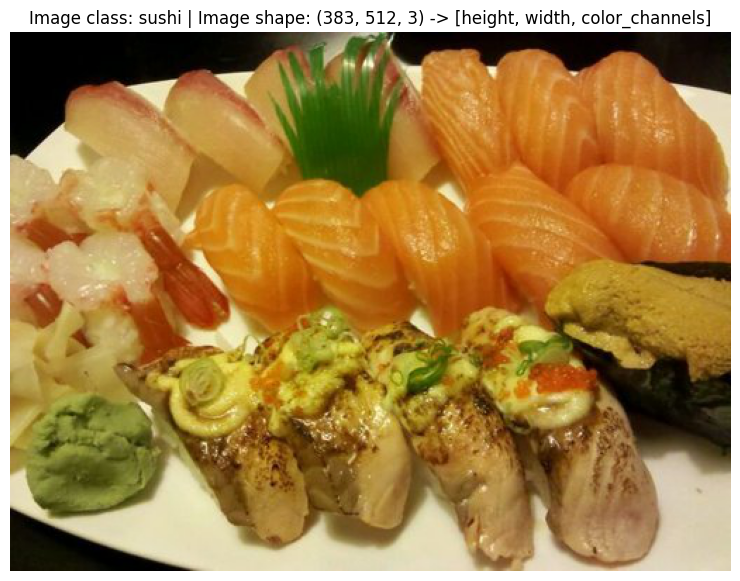

In [30]:
# Use matplotlib opening image
import numpy as np
import matplotlib.pyplot as plt

# 1. Turn image into array
img_as_array = np.asarray(img)

# 2. Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

# 3. Transforming data  
  
PyTorch can only process the data as tensor.
1. Trun target data into tensors
2. Trun it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`  
  in short `Dataset` and `DataLoader`.

In [31]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# 3.1 Transforming data with `torchvision.transforms`  
  
Transforms help we get images ready to be used with a model/perform data augmentation  
refer to : https://pytorch.org/vision/stable/transforms.html

In [33]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64 * 64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal (資料增強)
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()   # ToTensor needs PIL
])

In [41]:
print(data_transform(img).shape)
print(data_transform(img))

torch.Size([3, 64, 64])
tensor([[[0.0275, 0.0392, 0.0549,  ..., 0.0000, 0.0000, 0.0000],
         [0.0431, 0.0510, 0.0588,  ..., 0.0000, 0.0000, 0.0000],
         [0.0627, 0.0667, 0.0706,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.8471, 0.8510, 0.8549,  ..., 0.0667, 0.0706, 0.0667],
         [0.8667, 0.8667, 0.8627,  ..., 0.0706, 0.0706, 0.0706],
         [0.8706, 0.8784, 0.8784,  ..., 0.0784, 0.0745, 0.0706]],

        [[0.0235, 0.0235, 0.0235,  ..., 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0314, 0.0275,  ..., 0.0000, 0.0000, 0.0000],
         [0.0471, 0.0431, 0.0392,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.8157, 0.8078, 0.8078,  ..., 0.0706, 0.0706, 0.0667],
         [0.8235, 0.8196, 0.8196,  ..., 0.0745, 0.0667, 0.0667],
         [0.8275, 0.8314, 0.8392,  ..., 0.0706, 0.0627, 0.0627]],

        [[0.0157, 0.0157, 0.0235,  ..., 0.0000, 0.0000, 0.0000],
         [0.0118, 0.0078, 0.0157,  ..., 0.0000, 0.0000, 0.0000],
         [0.0196, 0.0196, 0.0235, 

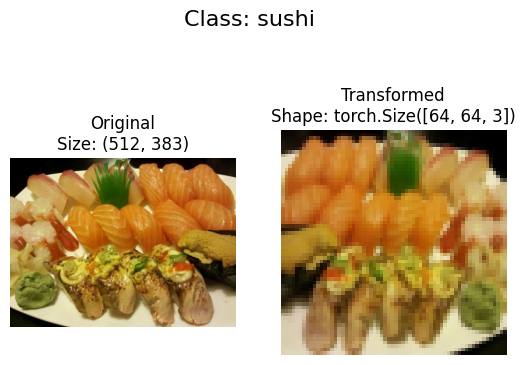

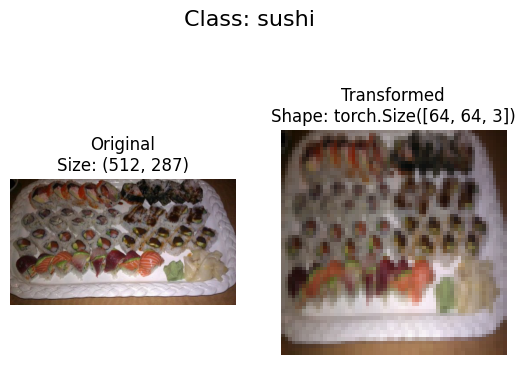

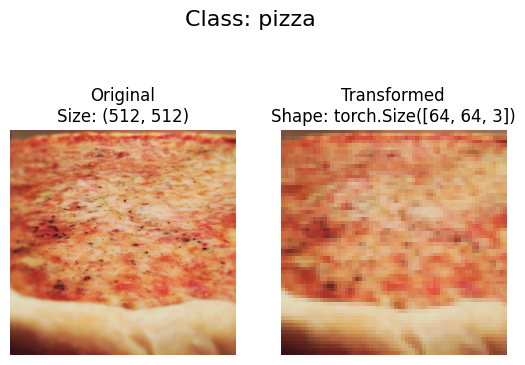

In [44]:
# Function
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
    """
    Select random images from path list
    loads / transforms them
    plots the original vs the transformed version
    """
    if seed:
        random.seed(seed)

    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # Transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0)   # note we will need to change shape for matplotlib
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

# Use function
plot_transformed_images(image_paths = image_path_list,
             transform = data_transform,
             n=3,
             seed=42)

# 4. Option 1: Loading imagedata using `ImageFolder`  
  
1. `ImageFolder` is a prebuild function
2. We can load image classification data using `torchvision.datasets.ImageFolder`

In [46]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                   transform=data_transform,   # a transform for the data
                   target_transform=None)   # a transform for the label
# 自動將圖片的所在資料夾名稱當作Label (to use function, need stander image classification format)

test_data = datasets.ImageFolder(root=test_dir,
                   transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))